for more scope creep, using a 30 (or 60 or 90) day price plot estimate the most likley day that the stock will peak and use this as the sell date.


In [1]:
import pandas as pd
from datetime import timedelta, time
from datetime import datetime
import numpy as np
#import yfinance as yf
import matplotlib.pyplot as plt
#from pandas.tseries.offsets import BMonthEnd
#import pickle
import joblib
#from ta.momentum import RSIIndicator
#from ta.trend import MACD
import itertools
import xgboost as xgb
from sklearn import metrics
#from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
#from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, precision_recall_curve # Loading required libraries
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

#import openinsider_scraper as OIScraper
import features as ft
import yfinance as yf

In [2]:
import features as ft
# if shit breaks it might be because in features I changed \$ to \\$ in str.replace('[\$,\+\-\%>]', '', regex=True)

### Todo:

Go through indicators and make ABSOLUTLY SURE that there is no data leakage or look-ahead bias. There must be no training on data after the effective transaction date, as we are not supposed to know data from the after then.

Try testing all the features with the chi squared test to see if two variables are independent (the feature and the thing we want to predict) 

Hyper parameter tuning

Train a model on just the last year or 6 months oof data and make sure the 10y model and the 1 year model agree price go up

when a trade is made on a monday before 9:30 the eff_trans_date is on the sunday, it should be prev friday

### Saving and loading varilabes with pickle, Joblib, and .save_model()

In [3]:
#os.makedirs('saved_vars', exist_ok=True)  # create folder if it doesn't exist

'''
Pickle
Saving a variable
'''
#with open('saved_vars/prices_for_all_tickers.pkl', 'wb') as f:
#    pickle.dump(prices, f)

'''
Loading a variable
'''
#with open('saved_vars/500_trades_from_mid_2024.pkl', 'rb') as f:  # 'rb' = read binary
#    data = pickle.load(f)

'''
JobLib
Saving a variable
'''
#Note: this took 2m 10s,  5m 30s,  for the 150k trades
#joblib.dump(df_by_ticker, 'saved_vars/35_features_2015_21-10-2025.joblib')


'''
Loading a variable
'''
#variable = joblib.load('filename.joblib')

'''
Models, saving and loading
Saving an XGboost model
'''
# Save to file
#model.save_model("my_model.json")

'''
Loading a model
'''
#loaded_model = xgb.XGBClassifier()
#loaded_model.load_model("my_model.json")


'\nLoading a model\n'

In [4]:
df = joblib.load('saved_vars/35_features_2015_21-10-2025.joblib')
# then 1m 30s
# then 3m
# then 1m 

In [5]:
#delete later

#joblib.dump(df, 'saved_vars/35_features_2015_21-10-2025.joblib')


In [6]:

#df = ft.update_latest_data(df)

In [7]:
#if 'SPY_1d_return' in df.columns:
#    df = df.drop('SPY_1d_return', axis = 1)
#spy_history = yf.Ticker('SPY').history(start=df['eff_trans_date'].min(), end=datetime.today())[['Open', 'High', 'Low', 'Close', 'Volume']]
#spy_returns = (spy_history['Close'] / spy_history['Open'] - 1).rename('SPY_1d_return')
#spy_returns.index = spy_returns.index.tz_localize(None)
#df = df.merge(spy_returns, left_on='eff_trans_date', right_index=True, how='left')

#temp = df['SPY_1d_return']
#temp

In [8]:

df_by_ticker = df.copy()
print(df_by_ticker.shape)
#remove rows with nans or neg nums in certain rows.
df_by_ticker = df_by_ticker.dropna()
min_stock_price = 2
df_by_ticker = df_by_ticker[df_by_ticker['last_price'] > min_stock_price]
df_by_ticker = df_by_ticker[(df_by_ticker[['last_price', 'Qty', 'shares_held', 'Owned', 'Value', 'Owned_norm', 'title_rank', 'filing_lad_days', 'same_day_trade_count']] >= 0).all(axis=1)]
print(df_by_ticker.shape)



(147679, 35)
(81769, 35)


In [9]:
todays_trades = df_by_ticker[df_by_ticker['eff_trans_date'] == df_by_ticker.iloc[-1]['eff_trans_date']]
df_by_ticker = df_by_ticker[df_by_ticker['eff_trans_date'] != df_by_ticker.iloc[-1]['eff_trans_date']]
df_by_ticker.shape


(81754, 35)

In [10]:
#joblib.dump(df, 'saved_vars/All_features_and_prices_df.joblib')

## Next Day Targets 0%, 2% , 5%, 10%.

In [11]:
# Precompute the relevant indices
open_prices = df_by_ticker['future_prices'].apply(lambda df: df['Open'].iloc[0])
print('Retreived day 1 open prices')
next_day_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[0])
print('Retreived day 1 close prices')


# Define thresholds
thresholds = [1, 1.02, 1.05, 1.1]

# Compute targets in a vectorised way
targets_dict = {}
for t in thresholds:
    targets_dict[f'next_day_{int((t-1)*100) if t != 1 else ""}%'] = next_day_close / open_prices > t


targets = pd.DataFrame(targets_dict)

del open_prices, next_day_close

Retreived day 1 open prices
Retreived day 1 close prices


## Key stats to beat 
### and facts about the target data.

In [12]:
prices = df_by_ticker['future_prices']
p = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open']) - 1




The following percentage increases are shown as a proportion percentage (i.e. 1 = 100%)
Mean:  0.00293681697656075
Meadian:  0.0
Standard deviation:  0.04231907543225707
Min:  -0.5500770139794846
Max:  2.5856699048417187



The following percentage increases are shown as a proportion percentage (i.e. 1 = 100%)
These do not include trades that return more than 0.5 (50% increase)
Mean:  0.0026306754678722157
Meadian:  0.0
Standard deviation:  0.037607817963562884


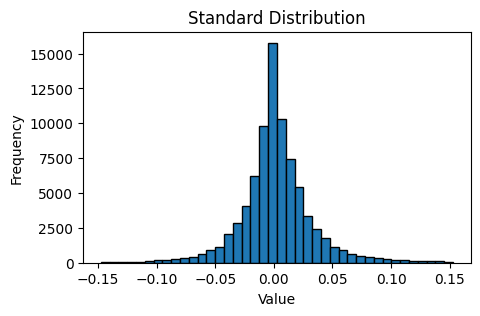

In [13]:

print('The following percentage increases are shown as a proportion percentage (i.e. 1 = 100%)')
print('Mean: ', p.mean())
print('Meadian: ', p.median())
print('Standard deviation: ', p.std())
print('Min: ', p.min())
print('Max: ', p.max())


pp = p[p <= 0.5] # this removes the top 100 trades
pp = pp[pp >= -0.5] # this removes the bottom ~5 trades



print('\n\n\nThe following percentage increases are shown as a proportion percentage (i.e. 1 = 100%)')
print('These do not include trades that return more than 0.5 (50% increase)')
print('Mean: ', pp.mean())
print('Meadian: ', pp.median())
print('Standard deviation: ', pp.std())




plt.figure(figsize=(5,3))
plt.hist(pp[abs(pp - pp.mean()) <= 4 * pp.std()], bins=40, edgecolor='black')
plt.title('Standard Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [14]:
targ = targets['next_day_2%']
length = len(targ)
print('Percentage proportion that go up at least 2%: ', targ.sum()/length)
print('prop that dont: ', 1 -targ.sum()/length )
print()

targ = targets['next_day_5%']
length = len(targ)
print('Percentage proportion that go up at least 5%: ', targ.sum()/length)
print('prop that dont: ', 1 -targ.sum()/length )


Percentage proportion that go up at least 2%:  0.20356190522787876
prop that dont:  0.7964380947721212

Percentage proportion that go up at least 5%:  0.06221102331384397
prop that dont:  0.937788976686156


## Prediction 1 day higher (1) lower (0) price movements 

## XGBoost

Detail about how to use XGBoost
https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03 

#### Analysis defs

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def model_eval(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Examine range of probabilities
    print("Min prob:", y_pred_proba.min(), "Max prob:", y_pred_proba.max())

    from sklearn.metrics import precision_recall_curve
    prec, rec, th = precision_recall_curve(y_test, y_pred_proba)
    prec, rec, th = prec[:-1], rec[:-1], th  # drop last precision/recall to match thresholds

    # Filter for thresholds that still yield some recall
    valid = rec > 0
    prec = prec[valid]
    rec = rec[valid]
    th = th[valid]

    # Choose threshold where precision >= recall (balanced conservatism)
    import numpy as np
    idx = np.argmax(prec >= rec)
    chosen_threshold = th[idx] if len(th) > 0 else 0.5

    y_pred = (y_pred_proba > chosen_threshold).astype(int)

    from sklearn.metrics import precision_score, recall_score, accuracy_score

    _precision_score = precision_score(y_test, y_pred)
    _recall_score = recall_score(y_test, y_pred)
    _accuracy_score = accuracy_score(y_test, y_pred)

    print(f"Threshold: {chosen_threshold:.3f}")
    print("Precision:", _precision_score, ' How many of the predicted up days were correct.')
    print("Recall:", _recall_score, ' How many up days were predicted as a proportion.') 
    print("Accuracy:", _accuracy_score)



  
    confusion_mtx = confusion_matrix(y_test, y_pred) 
    #print(confusion_mtx)
    plot_confusion_matrix(confusion_mtx, classes = range(2)) 

    return chosen_threshold, y_pred_proba, y_pred, _precision_score, _recall_score, _accuracy_score

#### Training toward precision on positive price up rather than general accuracy.

Index(['Qty', 'shares_held', 'Value', 'Owned_norm', 'title_rank',
       'is_during_market_hours', '1mo_return', '3mo_return', '30d_volatility',
       'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50', 'filing_lad_days',
       'month_end_flag', 'same_day_trade_count', 'day_sin', 'day_cos',
       'ATR_14', 'Vol_Ratio_20', 'SPY_1d_return'],
      dtype='object')
Number of trues:  1130
Number of fales:  15183
Percentage of faleses:  0.9307300925642126



Min prob: 0.00017737538 Max prob: 0.9229064
Threshold: 0.723
Precision: 0.22586359610274578  How many of the predicted up days were correct.
Recall: 0.22566371681415928  How many up days were predicted as a proportion.
Accuracy: 0.8927848954821308


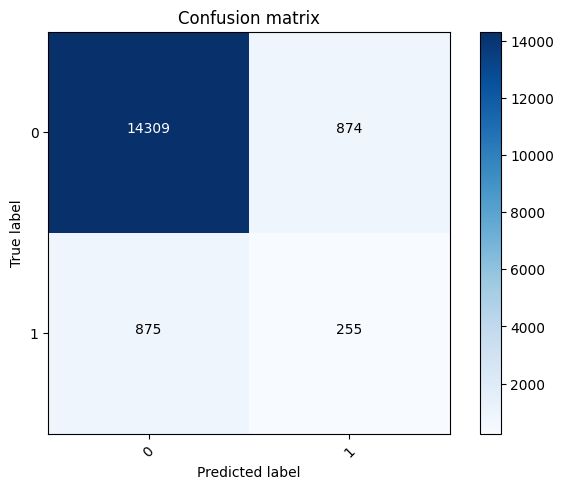

In [27]:

y = targets['next_day_5%']

X = df_by_ticker.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch'
    ,'last_price'
    ], axis=1)
print(X.columns)

#random split was found to inflate accuracy stats
split_date = df_by_ticker['eff_trans_date'].quantile(0.8)
train_idx = df_by_ticker['eff_trans_date'] <= split_date
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[~train_idx], y.loc[~train_idx]

print('Number of trues: ', len(y_test[y_test==1]))
print('Number of fales: ', len(y_test[y_test==0]))
print('Percentage of faleses: ', len(y_test[y_test==0])/(len(y_test[y_test==0]) + len(y_test[y_test==1])))
print()
print()
print()


pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

clf = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=pos_weight,  # bias gradient toward positive class
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)

chosen_threshold, y_pred_proba, y_pred, _precision_score, _recall_score, _accuracy_score = model_eval(clf, X_test, y_test) #optional return if you want to predict other dates.


In [17]:
#clf.save_model("saved_vars/XGBoost/23_10_2025_none_rand_spli_accuracy_0.85_threshold_0.736.json")


### Predicting tomorrows movements.

In [18]:
todays_trades_dropped = todays_trades.drop([
    'transaction_date', 'trade_date', 'eff_trans_date', 
    'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 
    'Title', 'transaction_type', 'Owned','trade_date_epoch', 'eff_trans_date_epoch',
    'last_price'
    ], axis=1)

display(todays_trades_dropped)

todays_trades_proba = clf.predict_proba(todays_trades_dropped)[:, 1]
todays_trades_pred = (todays_trades_proba > chosen_threshold).astype(int)

print(todays_trades_proba)
print(todays_trades_pred)
display(todays_trades[todays_trades_pred==1])

,Qty,shares_held,Value,Owned_norm,title_rank,is_during_market_hours,1mo_return,3mo_return,30d_volatility,rsi_14,...,volume_zscore,price_vs_sma50,filing_lad_days,month_end_flag,same_day_trade_count,day_sin,day_cos,ATR_14,Vol_Ratio_20,SPY_1d_return
147661,183.0,46019.0,21453.0,0.000000,2,True,-0.054937,-0.066019,0.240214,44.174543,...,-0.340089,0.965697,1.0,0,3,-0.433884,-0.900969,2.633865,1.025139,0.007415
147662,105.0,1812.0,12309.0,0.040736,2,True,-0.054937,-0.066019,0.240214,44.174543,...,-0.340089,0.965697,1.0,0,3,-0.433884,-0.900969,2.633865,1.025139,0.007415
147663,128.0,5377.0,15005.0,0.013767,2,True,-0.054937,-0.066019,0.240214,44.174543,...,-0.340089,0.965697,1.0,0,3,-0.433884,-0.900969,2.633865,1.025139,0.007415
147664,2295.0,11757.0,119914.0,0.153255,2,True,-0.128765,-0.079927,0.264289,32.896753,...,5.594238,0.918562,4.0,0,1,-0.433884,-0.900969,1.446246,3.386919,0.007415
147665,1.0,1162545.0,935.0,0.000000,1,True,0.028152,0.003437,0.396838,52.464563,...,-0.073064,1.025545,1.0,0,1,-0.433884,-0.900969,34.155709,1.075954,0.007415
147667,889.0,13588.0,60150.0,0.047362,2,False,0.009209,-0.176361,0.267235,48.430620,...,-0.577429,0.986301,2.0,0,1,-0.433884,-0.900969,1.382142,0.715875,0.007415
147668,68.0,68.0,8627.0,1.000000,2,False,-0.027645,0.074130,0.343576,50.873870,...,-0.524996,0.993794,72.0,0,1,-0.433884,-0.900969,3.562114,1.013635,0.007415
147669,59.0,45651.0,637.0,0.000000,3,False,-0.043828,-0.013460,0.161138,44.246167,...,-0.715595,0.965690,2.0,0,1,-0.433884,-0.900969,0.203571,0.744282,0.007415
147671,810.0,2580435.0,4455.0,0.000000,1,False,-0.023091,-0.066214,0.309624,45.876492,...,-0.854865,0.983337,1.0,0,1,-0.433884,-0.900969,0.160714,0.733032,0.007415
147672,72.0,1842.0,1000.0,0.027345,2,False,-0.049900,-0.156134,0.185621,39.121217,...,0.305112,0.945282,2.0,0,1,-0.433884,-0.900969,0.277143,0.890451,0.007415


[0.01470283 0.00476016 0.00997191 0.13307065 0.07386727 0.02308362
 0.0258114  0.00350571 0.06947757 0.00666016 0.49965286 0.12084103
 0.10174972 0.08278956 0.78629464]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


,transaction_date,trade_date,ticker,company_name,owner_name,Title,transaction_type,last_price,Qty,shares_held,...,volume_zscore,price_vs_sma50,filing_lad_days,month_end_flag,same_day_trade_count,day_sin,day_cos,ATR_14,Vol_Ratio_20,SPY_1d_return
147677,2025-10-17 18:54:20,2025-10-15,SOC,Sable Offshore Corp.,Pilgrim Global Icav,10%,P - Purchase,15.04,982645.0,10933394.0,...,1.192489,0.514028,2.0,0,1,-0.433884,-0.900969,1.746714,1.364757,0.007415


## Determining stop loss and take profit.

Average return:  0.013184158921624693

Take profit.
Av percentage prop between Open and high:  0.06555340938100686
Standard dev:  0.09225603815500698
25% of values are above: 0.08309454471649746
50% of values are above (median): 0.04166668994973155
75% of values are above: 0.016853916782002765


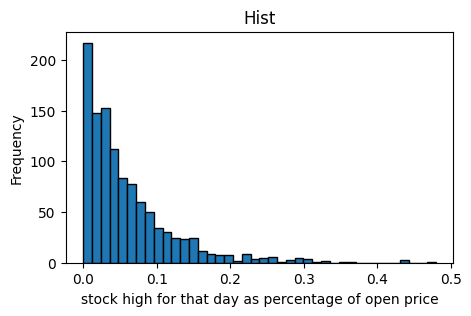


Take profit.
Av percentage prop between Open and low:  -0.04148568152764244
Standard dev:  0.039447471804415914
25% of values are below: -0.057283975705559986
50% of values are below (median): -0.03002312164699783
75% of values are below: -0.013565832731434191


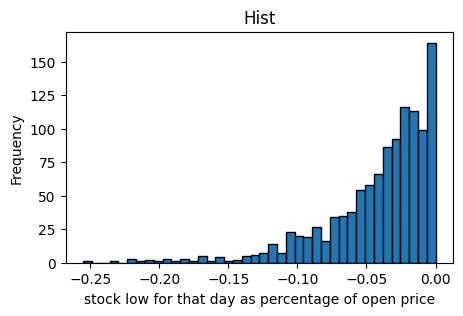

In [19]:
# Av Return, stop loss, take profit.

predicted_trues = X_test[y_pred==1]
prices = df_by_ticker.loc[predicted_trues.index]['future_prices']
close_over_open = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open'])
high_over_open = prices.apply(lambda df: df.iloc[0]['High'] / df.iloc[0]['Open'])
low_over_open = prices.apply(lambda df: df.iloc[0]['Low'] / df.iloc[0]['Open'])

x = close_over_open-1
print('Average return: ', x.mean())

x = high_over_open-1
print('\nTake profit.')
print('Av percentage prop between Open and high: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are above:', x.quantile(0.75))
print('50% of values are above (median):', x.quantile(0.5))
print('75% of values are above:', x.quantile(0.25))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x <= 0.5], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock high for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()


x = low_over_open-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are below:', x.quantile(0.25))
print('50% of values are below (median):', x.quantile(0.5))
print('75% of values are below:', x.quantile(0.75))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x >= -0.3], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()

Now looking at just the profitable trades (return > 0%) that were predicted trues.

(562,)

Take profit.
Av percentage prop between Open and low:  0.10353197099476792
Standard dev:  0.11321656263093441
25% of values are above: 0.12692194822157365
50% of values are above (median): 0.07396455166826699
75% of values are above: 0.04555503838646663


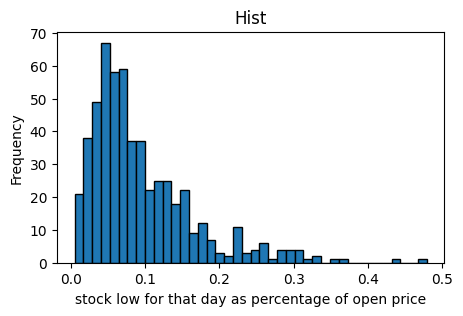


Take profit.
Av percentage prop between Open and low:  -0.022801934030287668
Standard dev:  0.025883428332596006
25% of values are below: -0.02959870134006068
50% of values are below (median): -0.016420376332828723
75% of values are below: -0.005579624723600962


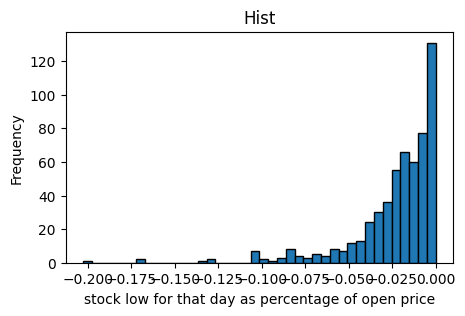

In [20]:
#predicted_trues = X_test[y_pred==1]
prices_rnt_profitable = prices[close_over_open > 1]

high_over_open_profitable = prices_rnt_profitable.apply(lambda df: df.iloc[0]['High'] / df.iloc[0]['Open'])
print(high_over_open_profitable.shape)
x = high_over_open_profitable-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are above:', x.quantile(0.75))
print('50% of values are above (median):', x.quantile(0.5))
print('75% of values are above:', x.quantile(0.25))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x <= 0.5], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()






low_over_open_profitable = prices_rnt_profitable.apply(lambda df: df.iloc[0]['Low'] / df.iloc[0]['Open'])
x = low_over_open_profitable-1
print('\nTake profit.')
print('Av percentage prop between Open and low: ', x.mean())
print('Standard dev: ',  x.std())
print('25% of values are below:', x.quantile(0.25))
print('50% of values are below (median):', x.quantile(0.5))
print('75% of values are below:', x.quantile(0.75))

plt.figure(figsize=(5,3))
#plt.hist(x, bins=40, edgecolor='black')
plt.hist(x[x >= -0.3], bins=40, edgecolor='black')
plt.title('Hist')
plt.xlabel('stock low for that day as percentage of open price')
plt.ylabel('Frequency')
plt.show()

## Model Analysis 

#### To be moved to another file eventually.

#### Inputs:

A pd df that contains the cols: `eff_trans_date, buy_price, sell_price, buy_date, sell_date`.

Starting Capital (dollars)

#### Output:

A pd df that contains the cols: `av_annual_returns, `. More to be added.

,start_balance,end_balance,avg_return,wins,losses,num_trades,annual_return_%,win_loss_ratio
eff_trans_date,,,,,,,,
2024,9901.000000,13695.099966,0.007887,139,233,372,38.320371,0.596567
2025,13709.912347,17251.784920,0.004949,142,268,410,25.834393,0.529851


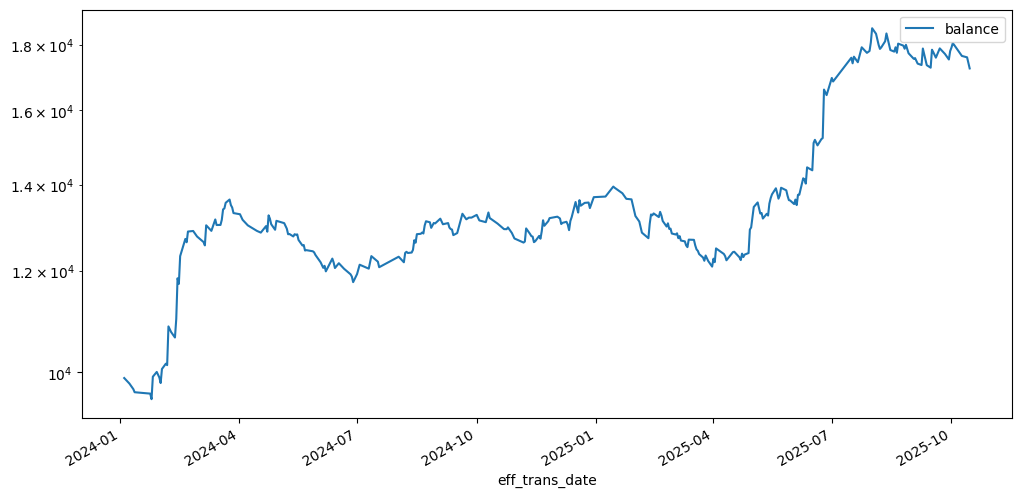

In [35]:
# params
spread_pct = 0.001     # round-trip spread assumption (0.1%)
slippage_pct = 0.001   # execution slippage (0.1%)
stop_loss = -0.03
take_profit = 10

X_test_temp = X_test.copy()
X_test_temp['probability'] = y_pred_proba #add the probability column to the X_test dataframe
predicted_trues = X_test_temp[y_pred==1]
pred_trades = df_by_ticker.loc[predicted_trues.index]
pred_trades = pred_trades[pred_trades["transaction_date"] > "2024-01-01 00:00:00"]
pred_trades = pred_trades.drop_duplicates(subset=['eff_trans_date', 'ticker'], keep='first')#drop duplicate trades

trades = pd.DataFrame(index=pred_trades.index)
trades['probability'] = trades.index.map(X_test_temp['probability'])
trades['eff_trans_date'] = pred_trades['eff_trans_date']
# buy at next-open (conservative: worse by half spread + slippage) (same for sell)
trades['buy_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])
trades['buy'] = pred_trades['future_prices'].apply(lambda df: df['Open'].iloc[0] * (1 + spread_pct/2 + slippage_pct))
trades['sell_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])  # same day
trades['sell'] = pred_trades['future_prices'].apply(lambda df: df['Close'].iloc[0] * (1 - spread_pct/2 - slippage_pct))
trades = trades.dropna(subset=['buy', 'sell'])
# compute returns
trades['returns_prop'] = trades['sell'] / trades['buy'] - 1
trades['returns_capped'] = trades['returns_prop'].clip(lower=stop_loss, upper=take_profit)
trades = trades.sort_values('eff_trans_date')


possible_to_stopout = True
if possible_to_stopout:
    trades['low'] = pred_trades['future_prices'].apply(lambda df: df['Low'].iloc[0])

    stopout_mask = trades['low'] < trades['buy'] * (1 + stop_loss)
    trades.loc[stopout_mask, 'returns_capped'] = stop_loss




starting_balance = 10000
balance = starting_balance
balances = []

#0.33 is used since the stop loss is set at 3%, meaning the largest daily loss is 1% of tot balance.
daily_total_risk = 0.33   # total fraction of account deployed across all trades that day

max_concurrent_positions = 20  # optional hard cap to avoid extreme concurrency

for date, group in trades.groupby('eff_trans_date'):
    # enforce concurrency cap
    group = group.iloc[:max_concurrent_positions]
    num_trades = len(group)
    capital_for_day = balance * daily_total_risk
    per_trade_capital = capital_for_day / max(1, num_trades)
    # compute per-trade profit in dollars
    daily_profit = (group['returns_capped'] * per_trade_capital).sum()
    balance += daily_profit
    balances.extend([balance] * num_trades)

trades = trades.loc[trades.index.isin([idx for g in trades.groupby('eff_trans_date') for idx in list(g[1].index)][:len(balances)])]  # ensure length match
trades['balance'] = balances



# Summary
trades['win'] = trades['returns_capped'] > 0
trades['loss'] = ~trades['win']
trades['profit_pct'] = trades['returns_capped'] * 100

summary = trades.groupby(trades['eff_trans_date'].dt.year).agg(
    start_balance=('balance', 'first'),
    end_balance=('balance', 'last'),
    avg_return=('returns_capped', 'mean'),
    wins=('win', 'sum'),
    losses=('loss', 'sum'),
    num_trades=('returns_capped', 'size')
)
summary['annual_return_%'] = (summary['end_balance']/summary['start_balance'] - 1) * 100
summary['win_loss_ratio'] = summary['wins'] / summary['losses']

display(summary)

trades.plot(x='eff_trans_date', y='balance', logy=True, figsize=(12, 6))
plt.show()



,start_balance,end_balance,avg_return,avg_capital_per_trade,total_capital_deployed,wins,losses,num_trades,annual_return_%,win_loss_ratio
eff_trans_date,,,,,,,,,,
2024,9901.00000,13698.131836,0.007887,1808.994141,672945.8125,139,233,372,38.350986,0.596567
2025,13781.15625,17343.458984,0.004949,1831.732178,751010.1875,142,268,410,25.849079,0.529851


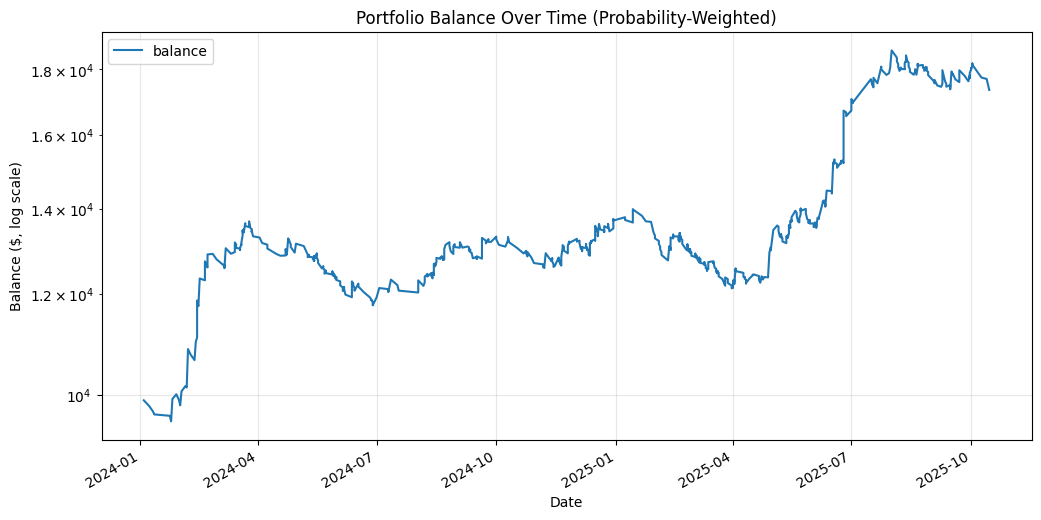

In [34]:

def run_probability_weighted_backtest(df_by_ticker, X_test, y_pred, y_pred_proba,
                                      starting_balance=10000,
                                      daily_total_risk=0.33,
                                      max_concurrent_positions=20,
                                      stop_loss=-0.03,
                                      take_profit=10,
                                      spread_pct=0.001,
                                      slippage_pct=0.001,
                                      start_date="2024-01-01 00:00:00",
                                      check_stopout=True):
    """
    Runs a backtest with probability-weighted capital allocation.
    
    Args:
        df_by_ticker: Main dataframe with trade data
        X_test: Test features
        y_pred: Binary predictions (0 or 1)
        y_pred_proba: Predicted probabilities
        starting_balance: Initial capital
        daily_total_risk: Fraction of account deployed across all trades per day
        max_concurrent_positions: Maximum number of positions per day
        stop_loss: Stop loss threshold (e.g., -0.03 for -3%)
        take_profit: Take profit cap
        spread_pct: Round-trip spread assumption
        slippage_pct: Execution slippage
        start_date: Filter trades after this date
        check_stopout: Whether to check for intraday stop-outs
        
    Returns:
        tuple: (trades DataFrame, summary DataFrame)
    """
    
    # Prepare data
    X_test_temp = X_test.copy()
    X_test_temp['probability'] = y_pred_proba
    
    predicted_trues = X_test_temp[y_pred == 1]
    pred_trades = df_by_ticker.loc[predicted_trues.index]
    pred_trades = pred_trades[pred_trades["transaction_date"] > start_date]
    pred_trades = pred_trades.drop_duplicates(subset=['eff_trans_date', 'ticker'], keep='first')
    
    # Build trades dataframe
    trades = pd.DataFrame(index=pred_trades.index)
    trades['probability'] = trades.index.map(X_test_temp['probability'])
    trades['eff_trans_date'] = pred_trades['eff_trans_date']
    
    # Calculate buy/sell prices with costs
    trades['buy_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])
    trades['buy'] = pred_trades['future_prices'].apply(
        lambda df: df['Open'].iloc[0] * (1 + spread_pct/2 + slippage_pct)
    )
    trades['sell_date'] = pred_trades['future_prices'].apply(lambda df: df.index[0])
    trades['sell'] = pred_trades['future_prices'].apply(
        lambda df: df['Close'].iloc[0] * (1 - spread_pct/2 - slippage_pct)
    )
    
    trades = trades.dropna(subset=['buy', 'sell'])
    
    # Compute raw returns
    trades['returns_prop'] = trades['sell'] / trades['buy'] - 1
    trades['returns_capped'] = trades['returns_prop'].clip(lower=stop_loss, upper=take_profit)
    
    # Check for stop-outs
    if check_stopout:
        trades['low'] = pred_trades['future_prices'].apply(lambda df: df['Low'].iloc[0])
        stopout_mask = trades['low'] < trades['buy'] * (1 + stop_loss)
        trades.loc[stopout_mask, 'returns_capped'] = stop_loss
    
    trades = trades.sort_values('eff_trans_date')
    
    # === PROBABILITY-WEIGHTED CAPITAL ALLOCATION ===
    balance = starting_balance
    balances = []
    capital_allocated_list = []
    
    for date, group in trades.groupby('eff_trans_date'):
        # Enforce concurrency cap
        group = group.iloc[:max_concurrent_positions]
        
        # Total capital available for this day
        capital_for_day = balance * daily_total_risk
        
        # Calculate weights based on probabilities
        prob_sum = group['probability'].sum()
        
        # Allocate capital proportionally to probability
        for idx, row in group.iterrows():
            # Weight = this trade's probability / sum of all probabilities
            weight = row['probability'] / prob_sum
            
            # Capital for this specific trade
            per_trade_capital = capital_for_day * weight
            capital_allocated_list.append(per_trade_capital)
            
            # Calculate profit/loss in dollars for this trade
            trade_pnl = row['returns_capped'] * per_trade_capital
            balance += trade_pnl
            balances.append(balance)
    
    # Attach results to trades
    trades = trades.iloc[:len(balances)]  # Ensure length match
    trades['balance'] = balances
    trades['capital_allocated'] = capital_allocated_list
    
    # Calculate metrics
    trades['win'] = trades['returns_capped'] > 0
    trades['loss'] = ~trades['win']
    trades['profit_pct'] = trades['returns_capped'] * 100
    trades['profit_dollars'] = trades['returns_capped'] * trades['capital_allocated']
    
    # Summary by year
    summary = trades.groupby(trades['eff_trans_date'].dt.year).agg(
        start_balance=('balance', 'first'),
        end_balance=('balance', 'last'),
        avg_return=('returns_capped', 'mean'),
        avg_capital_per_trade=('capital_allocated', 'mean'),
        total_capital_deployed=('capital_allocated', 'sum'),
        wins=('win', 'sum'),
        losses=('loss', 'sum'),
        num_trades=('returns_capped', 'size')
    )
    summary['annual_return_%'] = (summary['end_balance']/summary['start_balance'] - 1) * 100
    summary['win_loss_ratio'] = summary['wins'] / summary['losses']
    
    return trades, summary



trades, summary = run_probability_weighted_backtest(
    df_by_ticker=df_by_ticker,
    X_test=X_test,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    starting_balance=10000,
    daily_total_risk=0.33,
    max_concurrent_positions=20
)

# Display results
display(summary)

# Plot balance over time
trades.plot(x='eff_trans_date', y='balance', logy=True, figsize=(12, 6))
plt.title('Portfolio Balance Over Time (Probability-Weighted)')
plt.ylabel('Balance ($, log scale)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.show()
